In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import json
import os

import matplotlib.pyplot as plt

from collections import defaultdict

import Bio
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SubsMat import MatrixInfo as matlist

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pl_bolts.models import VAE

C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\Bio\SubsMat\__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [27]:
FILENAME = "spikeprot0112.fasta" 

In [33]:
viral_ids = []
viral_seqs = []
viral_countries = []
viral_dates = []


viral_seq_dict = defaultdict(lambda: 0)
viral_lengths = defaultdict(lambda: 0)
viral_countries_list = defaultdict(lambda: [])

idx = 0
for record in tqdm(SeqIO.parse(FILENAME, "fasta")):
    seq = str(record.seq[:-1])
    
    viral_ids.append(record.id)
    viral_seqs.append(seq)
    viral_country = record.description.split("|")[1].split("/")[1]
    viral_countries.append(viral_country)
    viral_date = record.description.split("|")[2]
    viral_dates.append(viral_date)

    viral_seq_dict[seq] += 1
    viral_lengths[len(seq)] += 1
    viral_countries_list[viral_country].append(idx)
    idx += 1

6908513it [02:41, 42704.32it/s]


# Descriptive analysis

## unique sequences

In [4]:
len(viral_seq_dict)

1360427

<BarContainer object of 1228 artists>

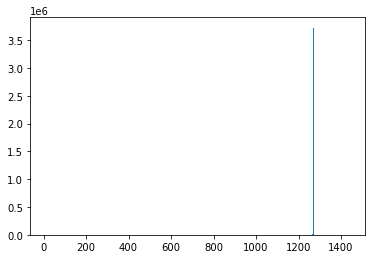

In [5]:
plt.bar(list(viral_lengths.keys()), list(viral_lengths.values()))

In [6]:
pd.DataFrame({"length": list(viral_lengths.keys()), "count": list(viral_lengths.values())}).sort_values("count", ascending=False)

,length,count
5,1271,3723928
0,1273,1613768
3,1270,1341619
7,1272,49190
58,835,28511
...,...,...
227,1303,1
1020,1299,1
999,1315,1
998,1284,1


# Variational Autoencoders

 ## Dataset and Tokenizer

In [ ]:
SEQ_LEN = 1271    # restricted to 1271 aa sequence lenghts

In [7]:
class StandardDataset(Dataset):

    def __init__(self, filename):
        viral_seq_dict = defaultdict(lambda: 0)
        for record in tqdm(SeqIO.parse(filename, "fasta")):
            seq = str(record.seq[:-1])
            viral_seq_dict[seq] += 1

        self.viral_seqs = []
        self.max_len = 0
        for seq in viral_seq_dict.keys():
            if len(seq) == SEQ_LEN:
                self.viral_seqs.append(seq)
            if len(seq) > self.max_len:
                self.max_len = len(seq)

    def __getitem__(self, idx):
        seq = tok.tokenize(self.viral_seqs[idx])
        return (seq, 1)

    def __len__(self):
        return len(self.viral_seqs)


class Tokenizer:
    def __init__(self, filename):
        f = open(filename)
        self.enc_dict = json.load(f)

    def tokenize(self, sequence):
        enc = []
        for aa in sequence:
            enc.append(self.enc_dict[aa])

        t = torch.tensor(enc)
        return t.float()

## Fully connected Encoder and Decoder

In [8]:
AA_ENC_DIM = 21   # count of amino acid encoding dimensions

# encoder parameters
ENC_INT_DIM = 512 # intermediate dimensions of the encoder
ENC_OUT_DIM = 128 # output dimensions of the encoder

# latent space
LATENT_DIM = 2   # dimensions of the latent space

# decoder parameters
DEC_INT_DIM = 512 # intermediate dimensions of the decoder

# VAE parameters
KL_COEFF = 0.1    # weighting of the KL divergence in the loss function


# training parameters
LR = 3e-4         # the learning rate
BATCH_SIZE = 64   # batch size

In [13]:
# lightning-bolts/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py
# https://github.com/PyTorchLightning/Lightning-Bolts/blob/master/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py#L18-L186

class Encoder_Fully(torch.nn.Module):
    def __init__(self,
        enc_input_dim: int,
        enc_int_dim: int,
        enc_out_dim: int
    ):
        super().__init__()
        self.enc_input_dim = enc_input_dim
        self.enc_int_dim = enc_int_dim
        self.enc_out_dim = enc_out_dim
        
        self.l1 = nn.Linear(self.enc_input_dim, self.enc_int_dim)
        self.l2 = nn.Linear(self.enc_int_dim, self.enc_out_dim)
        
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x
    
    
class Decoder_Fully(torch.nn.Module):
    def __init__(self, 
        latent_dim: int = LATENT_DIM,
        dec_int_dim: int = DEC_INT_DIM,
        dec_out_dim: int = AA_ENC_DIM*SEQ_LEN
    ):
        super().__init__()
        self.dec_input_dim = latent_dim
        self.dec_int_dim = dec_int_dim
        self.dec_out_dim = dec_out_dim
        
        self.l1 = nn.Linear(self.dec_input_dim, self.dec_int_dim)
        self.l2 = nn.Linear(self.dec_int_dim, self.dec_out_dim)
        
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x
    

class VAE_Fully(pl.LightningModule):
    """Standard VAE with Gaussian Prior and approx posterior.
    """

    def __init__(
        self,
        filename: str = FILENAME,
        aa_dim: int = AA_ENC_DIM,
        sequence_len: int = SEQ_LEN,
        enc_int_dim: int = ENC_INT_DIM,
        enc_out_dim: int = ENC_OUT_DIM,
        latent_dim: int = LATENT_DIM,
        dec_int_dim: int = DEC_INT_DIM,
        kl_coeff: float = KL_COEFF,
        lr: float = LR,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.filename = filename
        self.aa_dim = aa_dim
        self.sequence_len = sequence_len
        self.enc_int_dim = enc_int_dim
        self.enc_out_dim = enc_out_dim
        self.latent_dim = latent_dim
        self.dec_int_dim = dec_int_dim
        self.kl_coeff = kl_coeff
        self.lr = lr
        self.batch_size = batch_size


        self.ds = None
        self.dl = None

        self.encoder = Encoder_Fully(
            enc_input_dim = self.aa_dim*sequence_len,
            enc_int_dim = self.enc_int_dim,
            enc_out_dim = self.enc_out_dim)

        self.decoder = Decoder_Fully(
            latent_dim = self.latent_dim,
            dec_int_dim = self.dec_int_dim,
            dec_out_dim = self.aa_dim*sequence_len
        )

        self.fc_mu = nn.Linear(self.enc_out_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.enc_out_dim, self.latent_dim)

    def forward(self, x):
        x = x.view(-1, self.aa_dim*self.sequence_len)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return self.decoder(z)

    def _run_step(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return z, self.decoder(z), p, q

    def sample(self, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return p, q, z

    def step(self, batch, batch_idx):
        x, y = batch
        x = x.view(-1, self.aa_dim*self.sequence_len)
        z, x_hat, p, q = self._run_step(x)

        recon_loss = F.mse_loss(x_hat, x, reduction="mean")

        kl = torch.distributions.kl_divergence(q, p)
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = kl + recon_loss
        
        self.p = p
        self.q = q
        self.kl_loss = kl
        self.recon_loss = recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"val_{k}": v for k, v in logs.items()})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        self.ds = StandardDataset(self.filename)
        self.dl = DataLoader(self.ds,
                        shuffle=False,
                        batch_size=self.batch_size)
        return self.dl

In [14]:
SEP = os.sep

tok = Tokenizer(f"..{SEP}VAE{SEP}encodings{SEP}One_hot.json")

In [17]:
VAE = VAE_Fully()

trainer = Trainer(max_epochs=1, gpus=1)

print("ONLY sequences of length 1270 considered")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


ONLY sequences of length 1270 considered


In [18]:
trainer.fit(VAE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder_Fully | 13.7 M
1 | decoder | Decoder_Fully | 13.7 M
2 | fc_mu   | Linear        | 258   
3 | fc_var  | Linear        | 258   
------------------------------------------
27.4 M    Trainable params
0         Non-trainable params
27.4 M    Total params
109.706   Total estimated model params size (MB)

0it [00:00, ?it/s]
6074it [00:00, 60299.85it/s]
12276it [00:00, 61047.16it/s]
18381it [00:00, 60300.96it/s]
24412it [00:00, 59439.54it/s]
30358it [00:00, 59084.35it/s]
36424it [00:00, 59466.79it/s]
42548it [00:00, 59898.62it/s]
48539it [00:00, 59851.06it/s]
54643it [00:00, 60083.90it/s]
60741it [00:01, 60215.80it/s]
66877it [00:01, 60437.45it/s]
73049it [00:01, 60684.45it/s]
79206it [00:01, 60817.26it/s]
85288it [00:01, 59797.93it/s]
91272it [00:01, 58984.17it/s]
97294it [00:01, 59213.59it/s]
103426it [00:01, 59709.80it/s]
109548it [00:01, 60027.74i

Epoch 0:   3%|████                                                                                                                                                             | 241/9630 [00:42<27:36,  5.67it/s, loss=0.00645, v_num=19]


851599it [00:14, 59637.86it/s]
857912it [00:14, 60536.85it/s]
864156it [00:14, 60973.64it/s]
870380it [00:14, 61208.84it/s]
876522it [00:14, 61138.94it/s]
882774it [00:14, 61418.35it/s]
888918it [00:14, 60401.78it/s]
894963it [00:14, 60286.00it/s]
900995it [00:14, 60160.68it/s]
907202it [00:15, 60601.40it/s]
913407it [00:15, 60893.37it/s]
919587it [00:15, 61108.92it/s]
925773it [00:15, 61173.10it/s]
931956it [00:15, 61233.69it/s]
938098it [00:15, 61163.63it/s]
944235it [00:15, 61083.44it/s]
950344it [00:15, 59374.32it/s]
956292it [00:15, 58929.37it/s]
962323it [00:16, 59207.18it/s]
968468it [00:16, 59739.04it/s]
974541it [00:16, 59902.81it/s]
980658it [00:16, 60224.14it/s]
987003it [00:16, 61051.17it/s]
993169it [00:16, 61099.49it/s]
999368it [00:16, 61229.58it/s]
1005562it [00:16, 61314.22it/s]
1011695it [00:16, 60813.30it/s]
1017778it [00:16, 59983.28it/s]
1023789it [00:17, 59885.54it/s]
1029924it [00:17, 60189.02it/s]
1035998it [00:17, 60221.99it/s]
1042222it [00:17, 60690.42it/s]


2298230it [00:38, 59796.06it/s]
2304400it [00:38, 60223.16it/s]
2310470it [00:38, 60241.75it/s]
2316497it [00:38, 60119.27it/s]
2322511it [00:38, 58941.54it/s]
2328411it [00:38, 57820.69it/s]
2334504it [00:38, 58665.33it/s]
2340378it [00:38, 58562.18it/s]
2346551it [00:38, 59364.04it/s]
2352664it [00:38, 59748.21it/s]
2358642it [00:39, 59629.42it/s]
2364624it [00:39, 59563.22it/s]
2370705it [00:39, 59883.86it/s]
2376695it [00:39, 59231.13it/s]
2382621it [00:39, 57417.77it/s]
2388458it [00:39, 57567.36it/s]
2394629it [00:39, 58656.29it/s]
2400794it [00:39, 59410.85it/s]
2406855it [00:39, 59642.13it/s]
2412942it [00:39, 59876.61it/s]
2419133it [00:40, 60349.89it/s]
2425336it [00:40, 60711.87it/s]
2431473it [00:40, 60774.25it/s]
2437552it [00:40, 60648.73it/s]
2443618it [00:40, 59466.94it/s]
2449570it [00:40, 59355.02it/s]
2455614it [00:40, 59547.14it/s]
2461772it [00:40, 60020.08it/s]
2467956it [00:40, 60424.00it/s]
2474078it [00:40, 60529.24it/s]
2480312it [00:41, 60934.00it/s]
2486616i

3737738it [01:01, 56006.16it/s]
3743620it [01:01, 56669.54it/s]
3749917it [01:02, 58339.59it/s]
3756148it [01:02, 59359.04it/s]
3762450it [01:02, 60297.35it/s]
3768660it [01:02, 60771.88it/s]
3774901it [01:02, 61125.62it/s]
3781165it [01:02, 61441.18it/s]
3787326it [01:02, 61363.80it/s]
3793472it [01:02, 61253.42it/s]
3799604it [01:02, 60078.40it/s]
3805670it [01:02, 60114.39it/s]
3811688it [01:03, 60004.18it/s]
3817813it [01:03, 60242.83it/s]
3824008it [01:03, 60624.36it/s]
3830235it [01:03, 60969.22it/s]
3836505it [01:03, 61318.74it/s]
3842639it [01:03, 61185.93it/s]
3848759it [01:03, 60877.07it/s]
3854848it [01:03, 60396.80it/s]
3860889it [01:03, 59741.19it/s]
3866865it [01:04, 59612.11it/s]
3872867it [01:04, 59629.91it/s]
3878958it [01:04, 59879.81it/s]
3885100it [01:04, 60179.78it/s]
3891119it [01:04, 59880.32it/s]
3897272it [01:04, 60240.00it/s]
3903441it [01:04, 60533.16it/s]
3909688it [01:04, 60978.50it/s]
3915787it [01:04, 60135.56it/s]
3921803it [01:04, 59315.27it/s]
3927830i

5147915it [01:25, 55267.66it/s]
5153582it [01:25, 55553.80it/s]
5159609it [01:25, 56816.30it/s]
5165297it [01:26, 56386.91it/s]
5170940it [01:26, 55625.24it/s]
5176507it [01:26, 55196.77it/s]
5182250it [01:26, 55733.29it/s]
5188008it [01:26, 56122.91it/s]
5193875it [01:26, 56816.22it/s]
5199559it [01:26, 55712.44it/s]
5205136it [01:26, 54339.17it/s]
5210945it [01:26, 55310.83it/s]
5216929it [01:26, 56509.48it/s]
5222862it [01:27, 57222.68it/s]
5228592it [01:27, 56955.34it/s]
5234293it [01:27, 56515.87it/s]
5239949it [01:27, 54640.01it/s]
5245540it [01:27, 54891.32it/s]
5251469it [01:27, 56052.76it/s]
5257404it [01:27, 56898.61it/s]
5263487it [01:27, 57936.70it/s]
5269679it [01:27, 58988.78it/s]
5275795it [01:28, 59510.41it/s]
5282021it [01:28, 60191.92it/s]
5288204it [01:28, 60553.57it/s]
5294262it [01:28, 59896.85it/s]
5300255it [01:28, 58738.35it/s]
5306135it [01:28, 57292.97it/s]
5311922it [01:28, 57332.88it/s]
5317662it [01:28, 57060.18it/s]
5323373it [01:28, 56461.29it/s]
5329051i

6523945it [01:49, 56711.54it/s]
6529669it [01:49, 56739.77it/s]
6535346it [01:49, 55968.82it/s]
6541131it [01:50, 56396.69it/s]
6546774it [01:50, 55791.38it/s]
6552740it [01:50, 56816.28it/s]
6558964it [01:50, 58289.82it/s]
6565160it [01:50, 59256.84it/s]
6571089it [01:50, 58957.63it/s]
6576987it [01:50, 57817.28it/s]
6582775it [01:50, 52633.24it/s]
6588126it [01:50, 51219.01it/s]
6593360it [01:51, 51425.16it/s]
6598759it [01:51, 52043.17it/s]
6603998it [01:51, 51737.58it/s]
6609690it [01:51, 53125.34it/s]
6615603it [01:51, 54762.39it/s]
6621469it [01:51, 55788.29it/s]
6627062it [01:51, 55704.65it/s]
6632643it [01:51, 54495.83it/s]
6638213it [01:51, 54725.54it/s]
6643990it [01:51, 55508.54it/s]
6649548it [01:52, 52770.75it/s]
6654881it [01:52, 52820.31it/s]
6660548it [01:52, 53822.25it/s]
6666123it [01:52, 54262.35it/s]
6671753it [01:52, 54747.27it/s]
6677676it [01:52, 55955.95it/s]
6683658it [01:52, 56978.00it/s]
6689363it [01:52, 55562.14it/s]
6694931it [01:52, 53304.93it/s]
6700285i

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9630/9630 [15:20<00:00, 10.47it/s, loss=0.00594, v_num=20]


### Plot latent space

In [20]:
latents = []
Xs = []
Ys = []

for seq in tqdm(VAE.ds.viral_seqs):
    seq = torch.unsqueeze(tok.tokenize(seq), dim=0)
    encoded = VAE.encoder(seq.view(1, -1))
    mu = VAE.fc_mu(encoded)
    latents.append(mu)
    Xs.append(float(mu[0][0].detach()))
    Ys.append(float(mu[0][1].detach()))

 40%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 243804/616262 [16:59<25:56, 239.26it/s]


KeyboardInterrupt: 

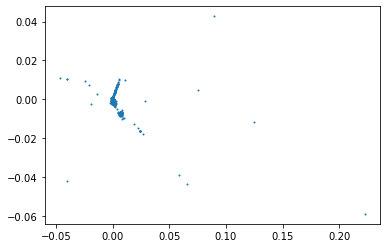

In [21]:
plt.scatter(Xs, Ys, s=1)

In [23]:
len(Xs)

243804

(-0.02, 0.02)

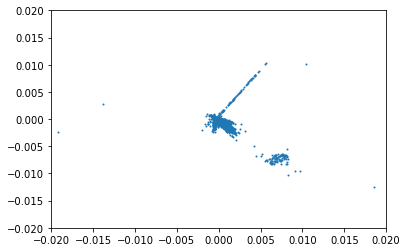

In [26]:
plt.scatter(Xs, Ys, s=1)
plt.xlim(-0.02, 0.02)
plt.ylim(-0.02, 0.02)

In [35]:
for country, indices in viral_countries_list.items():
    print(f"{country}: {len(indices)}")


Wuhan: 261
Philippines: 12817
Belgium: 77728
Wales: 140791
England: 1366662
India: 102823
Spain: 85400
Northern Ireland: 9685
Italy: 91143
North Macedonia: 702
Croatia: 14165
USA: 2223622
Ireland: 47645
Austria: 75665
Canada: 239150
Germany: 336093
Brazil: 92812
Turkey: 79889
Norway: 38916
Scotland: 159030
Poland: 41013
env: 2667
Cameroon: 554
Finland: 23012
Romania: 8926
Slovakia: 17978
Mexico: 43972
Slovenia: 45611
France: 185918
Australia: 53172
Malaysia: 7623
Zimbabwe: 709
Sweden: 139948
Hong Kong: 5273
Switzerland: 105789
Estonia: 8410
Netherlands: 88429
Costa Rica: 2338
Eswatini: 123
Portugal: 24682
Japan: 185866
Reunion: 5098
Nigeria: 3928
Martinique: 887
Mauritius: 531
Hungary: 435
Indonesia: 12209
Tunisia: 312
Israel: 38555
South Korea: 32479
French Guiana: 1195
Namibia: 438
Mayotte: 839
Kazakhstan: 637
Colombia: 11822
Monaco: 78
Latvia: 7858
Lithuania: 26904
Gambia: 1110
Aruba: 2731
cat: 98
Guadeloupe: 610
dog: 56
Belarus: 49
Panama: 1263
Singapore: 11615
South Africa: 26250


 14%|██████████████████████████▋                                                                                                                                                                | 22667/159030 [00:00<00:04, 29904.84it/s]


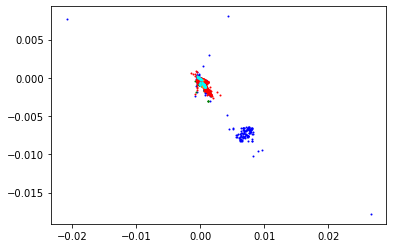

In [52]:
countries = ["USA", "England", "Germany", "Brazil", "Scotland"]
colors = ["blue", "green", "red", "orange", "cyan"]

X = []
Y = []

for country, color in zip(countries, colors):
    Xs, Ys = [], []
    
    for idx in tqdm(viral_countries_list[country]):
        seq = viral_seqs[idx]
        if len(seq) == SEQ_LEN:
            encoded = VAE.encoder(torch.unsqueeze(tok.tokenize(seq), dim=0).view(1, -1))
            mu = VAE.fc_mu(encoded)
            Xs.append(float(mu[0][0].detach()))
            Ys.append(float(mu[0][1].detach()))
            
        if idx > 1000000:
            break
     
    X.append(Xs)
    Y.append(Ys)
    plt.scatter(Xs, Ys, s=1, c=color)

(-0.01, 0.01)

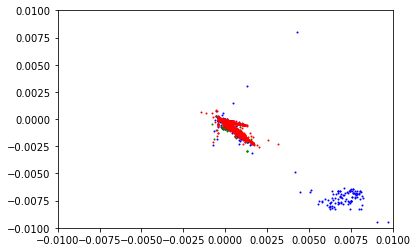

In [50]:
j = 0
plt.scatter(X[j], Y[j], s=1, c=colors[j])

j = 1
plt.scatter(X[j], Y[j], s=1, c=colors[j])

j = 2
plt.scatter(X[j], Y[j], s=1, c=colors[j])

plt.xlim(-0.01, 0.01)
plt.ylim(-0.01, 0.01)

Wuhan


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<?, ?it/s]


Philippines


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12817/12817 [00:13<00:00, 965.46it/s]


Belgium


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77728/77728 [03:07<00:00, 415.36it/s]


Wales


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140791/140791 [07:23<00:00, 317.39it/s]


England


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1366662/1366662 [1:07:20<00:00, 338.27it/s]


India


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102823/102823 [01:44<00:00, 981.40it/s]


Spain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85400/85400 [02:13<00:00, 640.06it/s]


Northern Ireland


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9685/9685 [00:11<00:00, 851.53it/s]


Italy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91143/91143 [02:56<00:00, 514.95it/s]


North Macedonia


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 1800.20it/s]


Croatia


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14165/14165 [00:40<00:00, 346.32it/s]


USA


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2223622/2223622 [1:33:56<00:00, 394.47it/s]


Ireland


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47645/47645 [01:49<00:00, 434.55it/s]


Austria


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75665/75665 [00:36<00:00, 2070.11it/s]


Canada


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239150/239150 [07:53<00:00, 505.32it/s]


Germany


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336093/336093 [13:17<00:00, 421.22it/s]


Brazil


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92812/92812 [02:13<00:00, 697.81it/s]


Turkey


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79889/79889 [03:38<00:00, 364.87it/s]


Norway


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38916/38916 [01:20<00:00, 484.93it/s]


Scotland


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159030/159030 [07:20<00:00, 361.14it/s]


Poland


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41013/41013 [01:42<00:00, 398.74it/s]


env


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2667/2667 [00:05<00:00, 509.46it/s]


KeyboardInterrupt: 

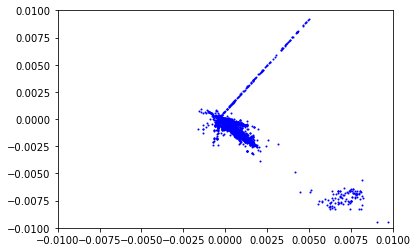

In [57]:
color = "blue"
X = []
Y = []

for country in viral_countries_list.keys():
    print(country)
    Xs, Ys = [], []
    
    for idx in tqdm(viral_countries_list[country]):
        seq = viral_seqs[idx]
        if len(seq) == SEQ_LEN:
            encoded = VAE.encoder(torch.unsqueeze(tok.tokenize(seq), dim=0).view(1, -1))
            mu = VAE.fc_mu(encoded)
            Xs.append(float(mu[0][0].detach()))
            Ys.append(float(mu[0][1].detach()))
     
    X.append(Xs)
    Y.append(Ys)
    
    plt.scatter(Xs, Ys, s=1, c=color)
    plt.xlim(-0.01, 0.01)
    plt.ylim(-0.01, 0.01)
    
    plt.savefig(f"pics/{country}.pdf")

In [58]:
country

'env'

## LSTM Encoder and Decoder

In [64]:
LSTM_HIDDEN_DIM = 512

In [90]:
# lightning-bolts/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py
# https://github.com/PyTorchLightning/Lightning-Bolts/blob/master/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py#L18-L186

class Encoder_LSTM(pl.LightningModule):
    def __init__(self,
        aa_dim: int,
        hidden_dim: int,
        enc_num_layers: int
    ):
        super().__init__()
        self.aa_dim = aa_dim
        self.hidden_dim = hidden_dim
        self.enc_num_layers = enc_num_layers
        
        self.lstm = nn.LSTM(self.aa_dim, self.hidden_dim, self.enc_num_layers, True, True, 0, False)
        
    def forward(self, x):
        batch_size, n_seq, n_embed = x.size()
        self.init_hidden(batch_size)
        _, (self.hidden, _) = self.lstm(x, self.hidden)
        return x
    
    def init_hidden(self, batch_size):
        h_0 = torch.zeros(self.enc_num_layers, batch_size, self.hidden_dim, device=self.device)
        c_0 = torch.zeros(self.enc_num_layers, batch_size, self.hidden_dim, device=self.device)
        self.hidden = (h_0, c_0)
    
    
class Decoder_LSTM(pl.LightningModule):
    def __init__(self, 
        aa_dim: int,
        hidden_dim: int,
        dec_num_layers: int
    ):
        super().__init__()
        self.aa_dim = aa_dim
        self.hidden_dim = hidden_dim
        self.dec_num_layers = dec_num_layers
        
        self.lstm = nn.LSTM(self.aa_dim, self.hidden_dim, self.dec_num_layers, True, True, 0, False)
        
    def forward(self, seq, hidden):
        x = self.lstm(seq, hidden)
        return x
    
    def init_hidden(self, batch_size):
        h_0 = torch.zeros(self.dec_num_layers, batch_size, self.dec_hidden_dim, device=self.device)
        c_0 = torch.zeros(self.dec_num_layers, batch_size, self.dec_hidden_dim, device=self.device)
        self.hidden = (h_0, c_0)
    

class VAE_LSTM(pl.LightningModule):
    """LSTM VAE with Gaussian Prior and approx posterior.
    """

    def __init__(
        self,
        filename: str = FILENAME,
        aa_dim: int = AA_ENC_DIM,
        hidden_dim: int = LSTM_HIDDEN_DIM,
        latent_dim: int = LATENT_DIM,
        kl_coeff: float = KL_COEFF,
        lr: float = LR,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.filename = filename
        self.aa_dim = aa_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.kl_coeff = kl_coeff
        self.lr = lr
        self.batch_size = batch_size


        self.ds = None
        self.dl = None

        self.encoder = Encoder_LSTM(
            aa_dim = self.aa_dim,
            hidden_dim = self.hidden_dim,
            enc_num_layers = 1)

        self.decoder = Decoder_LSTM(
            aa_dim = self.aa_dim,
            hidden_dim = self.hidden_dim,
            dec_num_layers = 1)

        self.fc_mu = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.hidden_dim, self.latent_dim)
        
    def generate_decoder_input(x):
        batch_size, seq_len, enc_dim = x.size()
        dec_seq = torch.zeros_like(x)
        dec_seq[:, 1:, :] = x[:, :-1, :]
        return dec_seq
        
    def forward(self, x):
        x = x.view(-1, self.aa_dim*self.sequence_len)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        dec_seq = self.generate_decoder_input(x)
        return self.decoder(dec_seq, z)

    def _run_step(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return z, self.decoder(z), p, q

    def sample(self, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return p, q, z

    def step(self, batch, batch_idx):
        x, y = batch
        #print(len(batch))
        #print(x.size())
        #x = x.view(-1, self.aa_dim*self.sequence_len)
        z, x_hat, p, q = self._run_step(x)

        recon_loss = F.mse_loss(x_hat, x, reduction="mean")

        kl = torch.distributions.kl_divergence(q, p)
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = kl + recon_loss
        
        self.p = p
        self.q = q
        self.kl_loss = kl
        self.recon_loss = recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"val_{k}": v for k, v in logs.items()})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        self.ds = StandardDataset(self.filename)
        self.dl = DataLoader(self.ds,
                        shuffle=False,
                        batch_size=self.batch_size)
        return self.dl

In [91]:
VAE_LSTM = VAE_LSTM()

In [92]:
trainer.fit(VAE_LSTM)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | encoder | Encoder_LSTM | 1.1 M 
1 | decoder | Decoder_LSTM | 1.1 M 
2 | fc_mu   | Linear       | 1.0 K 
3 | fc_var  | Linear       | 1.0 K 
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.774     Total estimated model params size (MB)

0it [00:00, ?it/s]
5308it [00:00, 52695.10it/s]
10973it [00:00, 54778.50it/s]
16788it [00:00, 56125.44it/s]
22401it [00:00, 53459.11it/s]
28086it [00:00, 54502.00it/s]
33551it [00:00, 54240.18it/s]
39177it [00:00, 54781.34it/s]
44663it [00:00, 53184.67it/s]
49994it [00:00, 52316.25it/s]
55235it [00:01, 51227.99it/s]
60445it [00:01, 51374.32it/s]
65978it [00:01, 52522.19it/s]
71238it [00:01, 51502.88it/s]
76396it [00:01, 51041.47it/s]
81929it [00:01, 52247.45it/s]
87172it [00:01, 52188.91it/s]
92462it [00:01, 52352.15it/s]
97702it [00:01, 52253.04it/s]
1029

1263376it [00:23, 52654.80it/s]
1268644it [00:23, 51386.40it/s]
1273790it [00:23, 51003.48it/s]
1279022it [00:23, 51278.49it/s]
1284255it [00:23, 51477.02it/s]
1289406it [00:23, 51290.42it/s]
1295135it [00:23, 52946.60it/s]
1301498it [00:23, 55997.44it/s]
1307102it [00:23, 55889.80it/s]
1312694it [00:24, 55612.91it/s]
1318258it [00:24, 54061.28it/s]
1323674it [00:24, 53508.26it/s]
1329069it [00:24, 53522.99it/s]
1334464it [00:24, 53529.34it/s]
1339821it [00:24, 53506.48it/s]
1345174it [00:24, 52989.88it/s]
1350624it [00:24, 53318.59it/s]
1355988it [00:24, 53382.41it/s]
1361352it [00:24, 53338.66it/s]
1366744it [00:25, 53389.90it/s]
1372153it [00:25, 53486.86it/s]
1377693it [00:25, 53939.58it/s]
1383088it [00:25, 53350.65it/s]
1388425it [00:25, 52537.63it/s]
1393709it [00:25, 52518.88it/s]
1399257it [00:25, 53274.24it/s]
1404959it [00:25, 54271.23it/s]
1410524it [00:25, 54562.47it/s]
1416067it [00:26, 54679.74it/s]
1421815it [00:26, 55393.27it/s]
1427400it [00:26, 55413.21it/s]
1432943i

2539557it [00:47, 53798.04it/s]
2545124it [00:47, 54316.00it/s]
2550773it [00:47, 54845.29it/s]
2556510it [00:47, 55478.01it/s]
2562058it [00:47, 54948.62it/s]
2567554it [00:47, 54671.33it/s]
2573022it [00:47, 53990.92it/s]
2578423it [00:47, 53727.45it/s]
2583976it [00:47, 54143.27it/s]
2589555it [00:47, 54513.31it/s]
2595008it [00:48, 54239.08it/s]
2600447it [00:48, 54166.48it/s]
2605865it [00:48, 54051.81it/s]
2611418it [00:48, 54371.94it/s]
2616918it [00:48, 54440.81it/s]
2622363it [00:48, 54004.78it/s]
2627765it [00:48, 53891.99it/s]
2633155it [00:48, 53619.04it/s]
2638518it [00:48, 53502.14it/s]
2643993it [00:48, 53837.76it/s]
2649416it [00:49, 53838.04it/s]
2654801it [00:49, 52625.99it/s]
2660070it [00:49, 52383.95it/s]
2665313it [00:49, 51824.51it/s]
2670499it [00:49, 50982.28it/s]
2675638it [00:49, 50992.59it/s]
2680759it [00:49, 50946.97it/s]
2685856it [00:49, 50525.09it/s]
2691059it [00:49, 50864.98it/s]
2696546it [00:49, 52013.89it/s]
2702020it [00:50, 52709.38it/s]
2707293i

3814979it [01:10, 53312.35it/s]
3820313it [01:10, 52584.99it/s]
3825754it [01:10, 53008.52it/s]
3831485it [01:11, 54163.49it/s]
3836905it [01:11, 53950.70it/s]
3842302it [01:11, 50841.80it/s]
3847727it [01:11, 51778.99it/s]
3853491it [01:11, 53362.73it/s]
3859067it [01:11, 53943.62it/s]
3864579it [01:11, 54251.53it/s]
3870019it [01:11, 52780.74it/s]
3875315it [01:11, 52190.82it/s]
3880546it [01:12, 52189.27it/s]
3886008it [01:12, 52789.69it/s]
3891481it [01:12, 53344.86it/s]
3897058it [01:12, 53999.38it/s]
3902628it [01:12, 54392.16it/s]
3908274it [01:12, 54884.85it/s]
3913902it [01:12, 55294.75it/s]
3919573it [01:12, 55628.68it/s]
3925138it [01:12, 55430.57it/s]
3930683it [01:12, 54585.62it/s]
3936145it [01:13, 53844.65it/s]
3941533it [01:13, 53739.61it/s]
3946939it [01:13, 53718.31it/s]
3952486it [01:13, 54120.11it/s]
3958009it [01:13, 54331.71it/s]
3963566it [01:13, 54581.48it/s]
3969338it [01:13, 55395.46it/s]
3974879it [01:13, 54313.10it/s]
3980315it [01:13, 54129.61it/s]
3985732i

5104611it [01:34, 54692.93it/s]
5110082it [01:34, 54418.03it/s]
5115525it [01:34, 54143.34it/s]
5120959it [01:34, 54102.60it/s]
5126370it [01:34, 53669.69it/s]
5131738it [01:35, 53085.87it/s]
5137048it [01:35, 52371.34it/s]
5142492it [01:35, 52942.05it/s]
5147996it [01:35, 53450.21it/s]
5153427it [01:35, 53685.29it/s]
5158798it [01:35, 53576.17it/s]
5164227it [01:35, 53671.98it/s]
5169596it [01:35, 53638.77it/s]
5175210it [01:35, 54266.81it/s]
5180638it [01:35, 54152.97it/s]
5186054it [01:36, 53207.20it/s]
5191379it [01:36, 52795.36it/s]
5197045it [01:36, 53819.14it/s]
5202711it [01:36, 54542.07it/s]
5208168it [01:36, 53303.31it/s]
5213652it [01:36, 53638.58it/s]
5219028it [01:36, 53652.73it/s]
5224662it [01:36, 54409.68it/s]
5230207it [01:36, 54600.04it/s]
5235670it [01:37, 54490.54it/s]
5241121it [01:37, 53619.93it/s]
5246633it [01:37, 53946.33it/s]
5252075it [01:37, 54062.97it/s]
5257651it [01:37, 54449.15it/s]
5263259it [01:37, 54808.02it/s]
5268842it [01:37, 54999.92it/s]
5274343i

6398247it [01:58, 54144.90it/s]
6403664it [01:58, 53719.03it/s]
6409214it [01:58, 54128.27it/s]
6414682it [01:58, 54166.26it/s]
6420100it [01:58, 53575.50it/s]
6425551it [01:58, 53729.89it/s]
6431197it [01:58, 54426.57it/s]
6436642it [01:59, 53912.02it/s]
6442121it [01:59, 54050.62it/s]
6447528it [01:59, 53937.36it/s]
6452923it [01:59, 53194.93it/s]
6458325it [01:59, 53311.69it/s]
6463679it [01:59, 53336.68it/s]
6469014it [01:59, 52291.46it/s]
6474563it [01:59, 53123.36it/s]
6479945it [01:59, 53316.76it/s]
6485530it [02:00, 53946.30it/s]
6490947it [02:00, 53973.10it/s]
6496347it [02:00, 53547.01it/s]
6501704it [02:00, 53284.30it/s]
6507292it [02:00, 53937.46it/s]
6512688it [02:00, 53668.64it/s]
6518083it [02:00, 53713.61it/s]
6523456it [02:00, 53601.96it/s]
6528817it [02:00, 53403.87it/s]
6534158it [02:00, 53130.95it/s]
6539568it [02:01, 53380.11it/s]
6544939it [02:01, 53367.15it/s]
6550540it [02:01, 54037.38it/s]
6555945it [02:01, 53224.04it/s]
6561270it [02:01, 52942.68it/s]
6566681i

Epoch 0:   0%|                                                                                                                                                                                                   | 0/9630 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 796.00 MiB (GPU 0; 6.00 GiB total capacity; 392.24 MiB already allocated; 3.80 GiB free; 410.00 MiB reserved in total by PyTorch)